# **Neural Networks for Multiclass Classification (CIFAR-10)**

## **Introduction**
This project demonstrates how to use **Neural Networks (CNNs with TensorFlow/Keras)** to solve a **multiclass image classification** problem on the **CIFAR-10 dataset**.

CIFAR-10 is a popular benchmark dataset in computer vision, consisting of **60,000 color images** (32×32 pixels) across **10 classes**:

- airplane  
- automobile  
- bird  
- cat  
- deer  
- dog  
- frog  
- horse  
- ship  
- truck  

### Objectives
Through this notebook, we will:
- Learn how to **load and preprocess image data**.  
- Build a **Convolutional Neural Network (CNN)** from scratch using TensorFlow/Keras.  
- Explore **optimizers** (Adam vs SGD) and their impact on training.  
- Apply best practices like **dropout**, **early stopping**, and **data augmentation**.  
- Evaluate results with **accuracy, confusion matrix, and per-class metrics**.  
- Visualize training progress using **matplotlib** and **TensorBoard**.  


### **Environment Setup & Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import os
import datetime


print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
GPU available: []


### **Loading and Exploring the CIFAR-10 Dataset**
We split it into:
- **Training set**: 50,000 images
- **Test set**: 10,000 images  

Before training a neural network:
- We **normalize** pixel values to `[0, 1]` (instead of `0–255`) for faster convergence.  
- We also **visualize a few samples** to understand the dataset better.


In [2]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()


x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

#Check dataset shape
print("Training data shape:", x_train.shape, y_train.shape)
print("Testing data shape:", x_test.shape, y_test.shape)


#Class names for CIFAR-10
class_names = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

Training data shape: (50000, 32, 32, 3) (50000, 1)
Testing data shape: (10000, 32, 32, 3) (10000, 1)


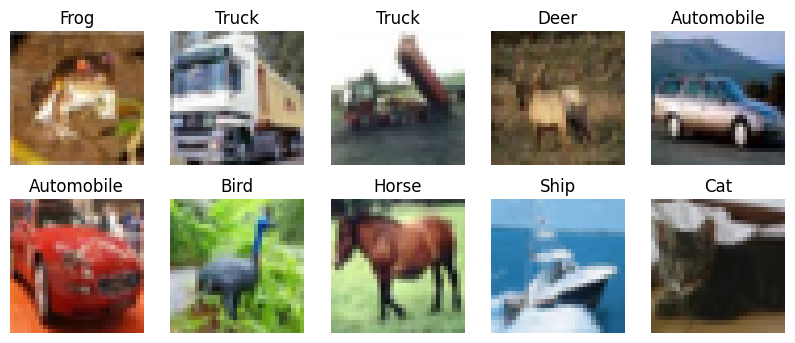

In [3]:
#Visualize some samples
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis("off")
plt.show()

## **Preprocessing Labels** (One-Hot Encoding)

Neural networks for classification usually output a **probability distribution** over classes.  
For CIFAR-10, we have **10 classes**, so the output layer should have **10 neurons** with a `softmax` activation.  

To train effectively, our labels (`y_train`, `y_test`) need to be in **one-hot encoded format**:  

- Example:  
  - Original label for "Cat" = `3`  
  - One-hot vector = `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`  

This helps the model match its predictions to the true class.


In [4]:
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

print("Original label:", y_train[0])
print("One-hot encoded label:", y_train_cat[0])


Original label: [6]
One-hot encoded label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## **Building the CNN Model**

We’ll use a **Convolutional Neural Network (CNN)**, since it works best for images.  
Key building blocks:  

1. **Convolutional layers (`Conv2D`)** → detect patterns (edges, textures, shapes).  
2. **Activation (`ReLU`)** → adds non-linearity.  
3. **Pooling layers (`MaxPooling2D`)** → reduce spatial size (downsampling).  
4. **Dropout** → prevents overfitting by randomly "turning off" neurons.  
5. **Fully connected (`Dense`) layers** → combine features and classify.  
6. **Output layer (`Dense` with `softmax`)** → probability distribution over 10 classes.  

Our first CNN will be a simple baseline:
- Two convolutional + pooling blocks
- One fully connected hidden layer
- Softmax output


In [5]:

model = models.Sequential([
    keras.Input(shape=(32, 32, 3)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),


    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(10, activation="softmax")
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 167,562 (654.54 KB)

 Trainable params: 167,562 (654.54 KB)

 Non-trainable params: 0 (0.00 B)

### **Compiling the Model**

Before training, we must **compile** the model.  
Compilation defines *how* the network will learn:

- **Loss function**:  
  - Since this is **multiclass classification**, we use  
    `categorical_crossentropy` (for one-hot labels).  
- **Optimizer**:  
  - We’ll start with `Adam` (adaptive learning, usually faster than vanilla SGD).  
- **Metrics**:  
  - We track `accuracy` to measure performance during training.  

This step doesn’t train the model — it just prepares it for training.


In [6]:
model.compile(
    optimizer="adam",                     
    loss="categorical_crossentropy",      
    metrics=["accuracy"]                  
)


### **Training the Model**

Now that the model is compiled, we can train it using `model.fit()`.

Key points:
- **Epochs**: how many times the model will see the full training dataset.  
- **Batch size**: number of samples processed before updating weights.  
- **Validation split**: we set aside part of the training data to monitor generalization.  
- **Callbacks**: optional helpers to improve training, like:
  - **EarlyStopping** → stop if validation loss doesn’t improve.  
  - **TensorBoard** → visualize training in real time.  

We’ll first train with a **basic setup** (just epochs, batch size, validation), then later add callbacks for improvements.


In [7]:

history = model.fit(
    x_train, y_train_cat,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.3098 - loss: 1.8555 - val_accuracy: 0.4855 - val_loss: 1.5133
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4266 - loss: 1.5570 - val_accuracy: 0.5242 - val_loss: 1.3463
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4757 - loss: 1.4364 - val_accuracy: 0.5594 - val_loss: 1.2491
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5021 - loss: 1.3601 - val_accuracy: 0.5988 - val_loss: 1.1650
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5245 - loss: 1.3089 - val_accuracy: 0.6174 - val_loss: 1.0971
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5477 - loss: 1.2495 - val_accuracy: 0.6356 - val_loss: 1.0728
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5624 - loss: 1.2169 - val_accuracy: 0.6298 - val_loss: 1.0739
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5763 - loss: 1.1737 - val_acc

### **Visualizing Training Progress**

The `model.fit()` call returns a **history object** that stores training logs:
- Training loss and accuracy  
- Validation loss and accuracy  

We can plot these metrics using **matplotlib** to check:
- Whether the model is learning (loss decreasing, accuracy increasing).  
- If the model is **overfitting** (validation loss goes up while training loss goes down).


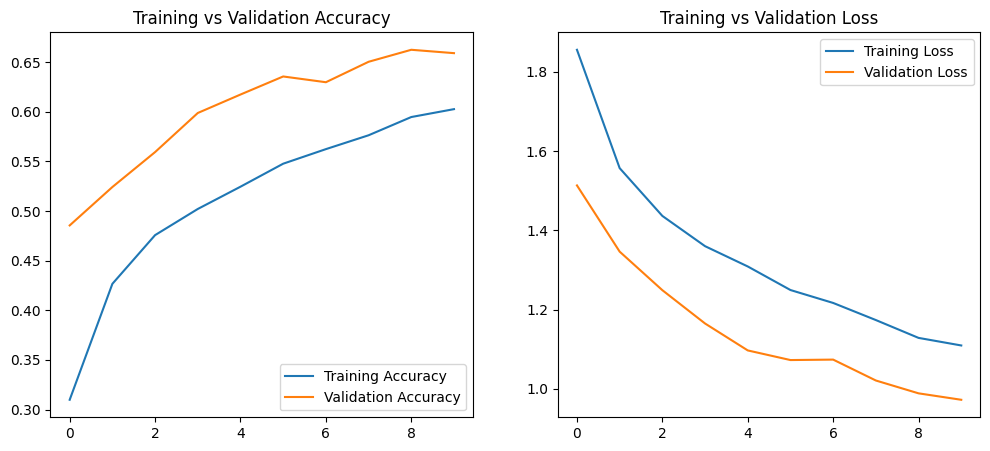

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training vs Validation Accuracy")

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training vs Validation Loss")

plt.show()

### **Improving Training with Callbacks**

Neural networks can easily **overfit** if trained for too many epochs.  
Instead of manually guessing when to stop, we use **callbacks**:

- **EarlyStopping**: stops training if validation loss doesn’t improve for a while.  
- **ModelCheckpoint**: saves the best version of the model during training.  
- **TensorBoard**: lets us visualize metrics (accuracy, loss, learning curves) in an interactive dashboard.  

This way, we don’t waste time overtraining, and we keep the best-performing model.


In [9]:
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True),
    TensorBoard(log_dir=log_dir, histogram_freq=1)
]

history_cb = model.fit(
    x_train, y_train_cat,
    epochs=20,              
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6116 - loss: 1.0770 - val_accuracy: 0.6678 - val_loss: 0.9594
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6237 - loss: 1.0533 - val_accuracy: 0.6742 - val_loss: 0.9436
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6306 - loss: 1.0202 - val_accuracy: 0.6702 - val_loss: 0.9476
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6396 - loss: 1.0038 - val_accuracy: 0.6715 - val_loss: 0.9417
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6476 - loss: 0.9737 - val_accuracy: 0.6822 - val_loss: 0.9158
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6526 - loss: 0.9657 - val_accuracy: 0.6739 - val_loss: 0.9431
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6576 - loss: 0.9410 - val_accuracy: 0.6880 - val_loss: 0.9192
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6638 - loss: 0.9222 - val_accu

## **Evaluating the Model on the Test Set**

After training, we must evaluate the model on the **unseen test set**.  
This step tells us how well the network generalizes to new data.

We’ll compute:
- **Test loss & accuracy** (basic performance numbers).  
- **Confusion matrix** to see per-class performance.  
- **Classification report** (precision, recall, F1-score per class).  

This is important because overall accuracy can hide weaknesses
for example, the model might do well on "cars" but poorly on "cats".


In [10]:
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test.flatten()


Test Accuracy: 0.6910
Test Loss: 0.8959
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


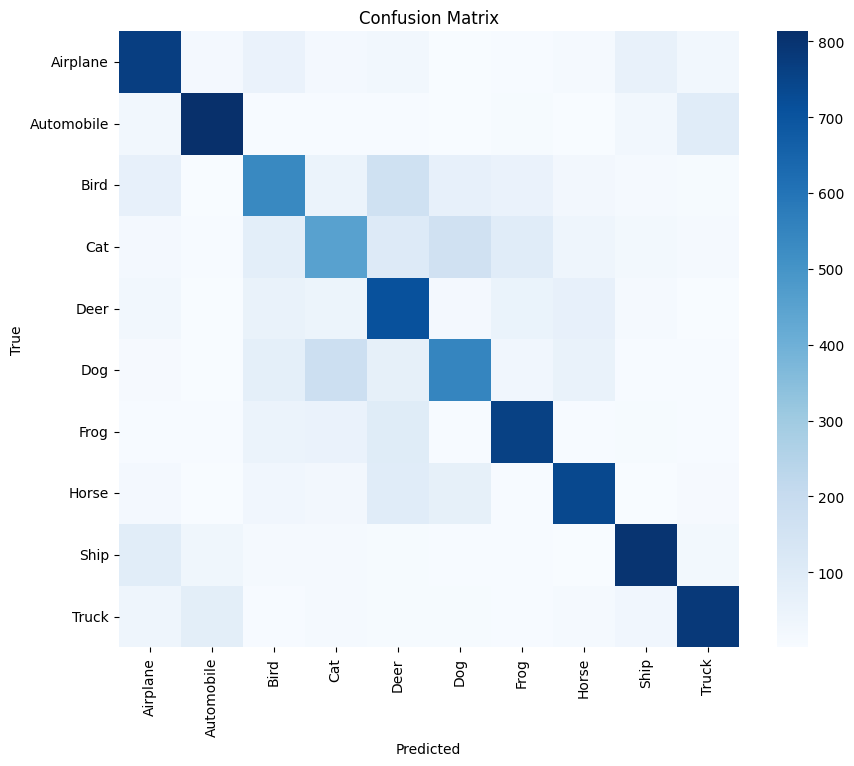

In [11]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [12]:
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


Classification Report:

              precision    recall  f1-score   support

    Airplane       0.71      0.77      0.74      1000
  Automobile       0.84      0.81      0.83      1000
        Bird       0.58      0.54      0.56      1000
         Cat       0.52      0.45      0.49      1000
        Deer       0.55      0.71      0.62      1000
         Dog       0.61      0.55      0.58      1000
        Frog       0.74      0.76      0.75      1000
       Horse       0.76      0.74      0.75      1000
        Ship       0.81      0.80      0.80      1000
       Truck       0.80      0.78      0.79      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



## **Adding Data Augmentation**

One challenge with CIFAR-10 is **overfitting** — the model can memorize training images instead of learning general patterns.  
To reduce this, we apply **data augmentation**: creating *slightly modified versions* of the training images (rotated, shifted, flipped, etc.).  

This improves generalization because the model sees more variety during training.

We’ll use:
- **Random rotations & shifts**
- **Horizontal flips**
- **Zooming**

Then we’ll train the same CNN with this augmented dataset and compare performance.


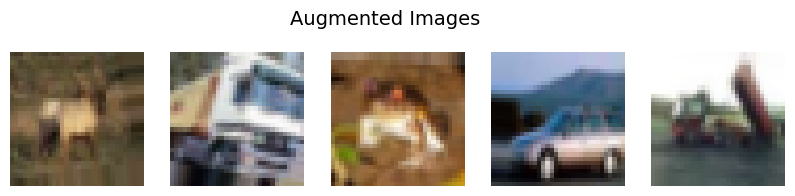

In [20]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

#Fit the generator on training data
datagen.fit(x_train)

#show augmented images
sample_images = x_train[:5]

plt.figure(figsize=(10, 4))
for i, batch in enumerate(datagen.flow(sample_images, batch_size=5)):
    for j in range(5):
        plt.subplot(2, 5, j+1)
        plt.imshow(batch[j])
        plt.axis("off")
    break
plt.suptitle("Augmented Images", fontsize=14)
plt.show()




In [21]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='keras')

#new model with augmentation
model_aug = models.Sequential([
        keras.Input(shape=(32, 32, 3)),
        layers.Conv2D(32, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),

        layers.Dense(10, activation="softmax")
    ])
    
model_aug.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

callbacks_2 = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True),
    TensorBoard(log_dir=log_dir, histogram_freq=1)
]

history_aug = model_aug.fit(
    datagen.flow(x_train, y_train_cat, batch_size=64),
    validation_data=(x_test, y_test_cat),
    epochs=30,
    callbacks=callbacks_2,  
    verbose=1
)


Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.3180 - loss: 1.8418 - val_accuracy: 0.4579 - val_loss: 1.4762
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.4133 - loss: 1.6087 - val_accuracy: 0.5371 - val_loss: 1.3086
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.4505 - loss: 1.5167 - val_accuracy: 0.5409 - val_loss: 1.2460
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.4738 - loss: 1.4516 - val_accuracy: 0.5833 - val_loss: 1.1702
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.4955 - loss: 1.4020 - val_accuracy: 0.6179 - val_loss: 1.0990
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.5136 - loss: 1.3623 - val_accuracy: 0.6140 - val_loss: 1.1033
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.5217 - loss: 1.3341 - val_accuracy: 0.6090 - val_loss: 1.1302
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.5334 - loss: 1.3156 - 

## **Evaluate and Compare Model Performance**

Now that we have trained the model with and without data augmentation, 
let's evaluate both versions on the test set.

We will:

- Compute overall accuracy
- Plot the confusion matrix
- Compare per-class accuracy
- Visualize training and validation curves


In [22]:
loss_no_aug, acc_no_aug = model.evaluate(x_test, y_test_cat, verbose=0)
loss_aug, acc_aug = model_aug.evaluate(x_test, y_test_cat, verbose=0)

print(f"Original (No Aug) Test Accuracy: {acc_no_aug:.4f}")
print(f"Augmented Model Test Accuracy: {acc_aug:.4f}")


y_pred_no_aug = model.predict(x_test).argmax(axis=1)
y_pred_aug = model_aug.predict(x_test).argmax(axis=1)
y_true = y_test.flatten()

Original (No Aug) Test Accuracy: 0.6910
Augmented Model Test Accuracy: 0.6943
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


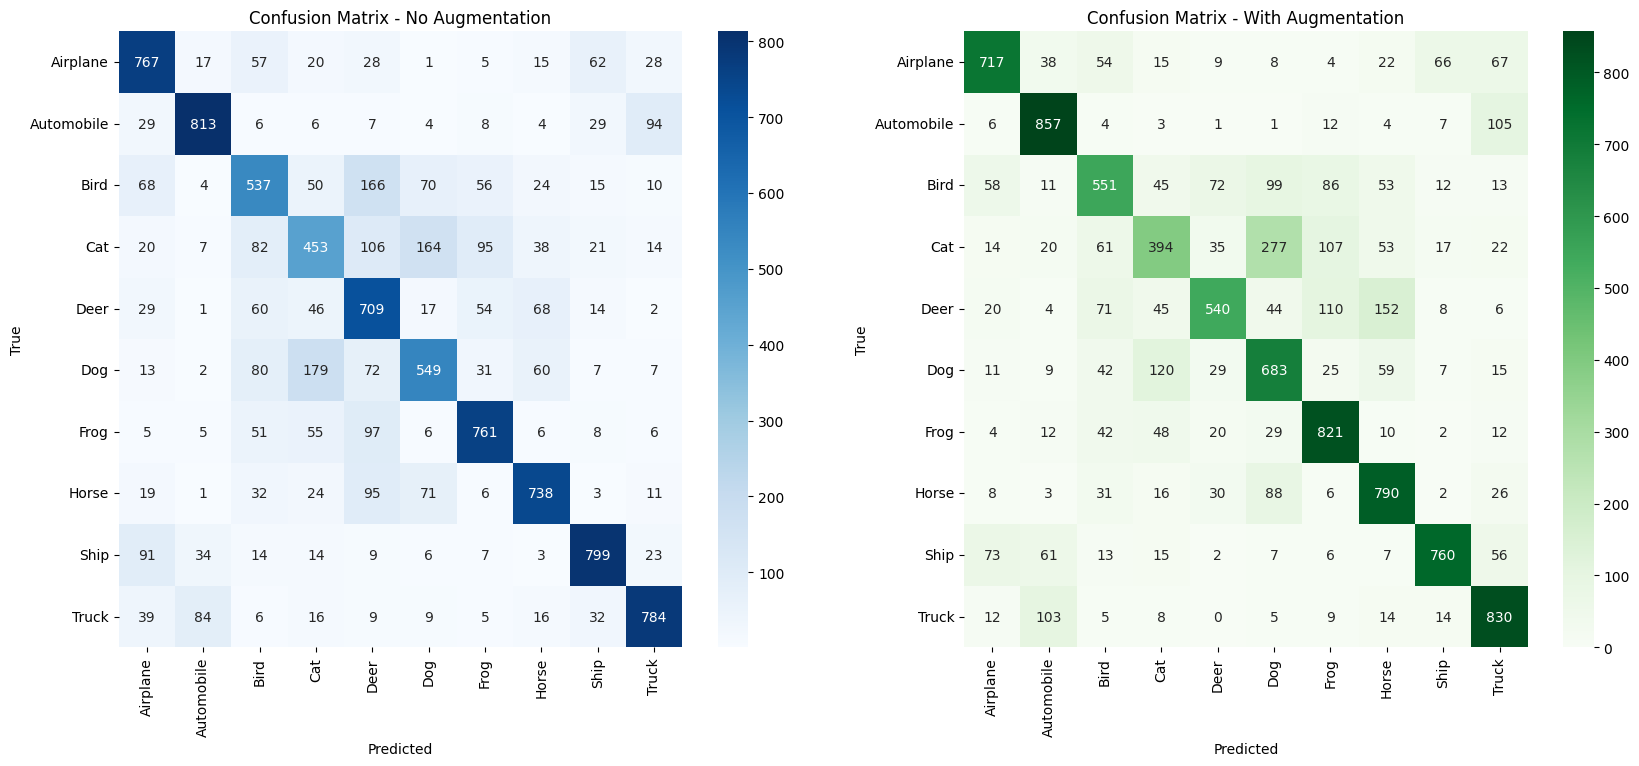

In [23]:

cm_no_aug = confusion_matrix(y_true, y_pred_no_aug)
cm_aug = confusion_matrix(y_true, y_pred_aug)

plt.figure(figsize=(20,8))

# No Aug CM
plt.subplot(1,2,1)
sns.heatmap(cm_no_aug, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - No Augmentation")
plt.xlabel("Predicted")
plt.ylabel("True")

# Augmented CM
plt.subplot(1,2,2)
sns.heatmap(cm_aug, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - With Augmentation")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()


In [24]:

print("Classification Report - No Augmentation")
print(classification_report(y_true, y_pred_no_aug, target_names=class_names))

print("Classification Report - With Augmentation")
print(classification_report(y_true, y_pred_aug, target_names=class_names))

Classification Report - No Augmentation
              precision    recall  f1-score   support

    Airplane       0.71      0.77      0.74      1000
  Automobile       0.84      0.81      0.83      1000
        Bird       0.58      0.54      0.56      1000
         Cat       0.52      0.45      0.49      1000
        Deer       0.55      0.71      0.62      1000
         Dog       0.61      0.55      0.58      1000
        Frog       0.74      0.76      0.75      1000
       Horse       0.76      0.74      0.75      1000
        Ship       0.81      0.80      0.80      1000
       Truck       0.80      0.78      0.79      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000

Classification Report - With Augmentation
              precision    recall  f1-score   support

    Airplane       0.78      0.72      0.75      1000
  Automobile       0.77      0.86      0.81      1


## **Conclusion**

* We trained a **Convolutional Neural Network (CNN)** on the **CIFAR-10 dataset** for multiclass classification (10 object categories).
* The **baseline model (no augmentation)** reached \~69% accuracy.
* The **augmented model** also achieved \~69% accuracy, but showed slightly different strengths:

  * Better performance on classes like **Automobile, Dog, Frog, Horse, Truck**.
  * Slightly weaker performance on **Cat, Deer**.
* This highlights an important tradeoff:

  * **Without augmentation** → the model learns faster but may overfit.
  * **With augmentation** → the model learns more robust features, generalizes better to unseen variations, but needs more epochs or a larger network to fully outperform the baseline.

